In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes
import gym
import gym_combrf

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas

## Create channel variation for every location in the environment

In [3]:
#create a channel variation of vectors, one for each location in environment

#create same channel variation over time for all location, as we train MAB separately for every location.
#This can then be compared with DQN with same channel variation over time.

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]


## Perform MAB for each location inside the coverage area

In [4]:
import math
mab_env = gym.make('combrf-v4')

print(mab_env.ch_model)
print(mab_env.sc_xyz)

uma-los
[]


In [5]:
#MAB for one location
def implement_gUCB(n, num_actions, env, tx_loc, txbdir_ndx, Qvals, num_selections, ch_randval):
    
    totalrwd = 0
    alpha = 0.999
    selected_actions = []
    ep_datarates = []
    
    #for n in range(N):
    action_ndx = env.reset(tx_loc, tbdir_ndx, ch_randval)
    max_upperbound = 0
    for i in range(num_actions):
        if(num_selections[i] > 0):
            avg_rwd = Qvals[i] / num_selections[i]
            delta_i = math.sqrt(2*math.log(n+1)/num_selections[i])
            upper_bound = (1-alpha)*avg_rwd + (alpha)*delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upperbound:
            max_upperbound = upper_bound
            action_ndx = i
    selected_actions.append(action_ndx)
    num_selections[action_ndx] += 1
    rwd, done = env.step(action_ndx)
    #ep_datarates.append(env.get_rate())
    Qvals[action_ndx] += rwd
    #totalrwd += rwd
    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(Qvals,num_selections)]
    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    datarate = env.compute_data_rate(best_action_ndx)
    min_exhrate, max_exhrate, min_action_ndx, max_action_ndx, _, _ = env.get_minmax_exhrate(ch_randval)        
    return rwd, best_action_ndx, datarate, min_exhrate, max_exhrate

In [6]:
def moving_scatters(init_scpts, grid_stepsize, episodes):
    moving_rpts = [[np.array([rp_loc])] for rp_loc in init_scpts]

    #print("Initial: \n", moving_rpts)

    for i in range(2):
        for ndx in range(len(moving_rpts)):
            if (ndx == 0) or (ndx == 1):
                last_loc = moving_rpts[ndx][-1]
                new_loc = np.array([[last_loc[0][0]+grid_stepsize, last_loc[0][1], last_loc[0][2]]]) 
                moving_rpts[ndx].append(new_loc)
            elif (ndx == 2) or (ndx == 3):
                last_loc = moving_rpts[ndx][-1]
                new_loc = np.array([[last_loc[0][0], last_loc[0][1]-grid_stepsize, last_loc[0][2]]]) 
                moving_rpts[ndx].append(new_loc)
    print("After adding moving patterns: ", moving_rpts)
    
    eps_scpts = []
    for i in range(episodes):
        #print(random.choice(moving_rpts[0]))
        sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
        eps_scpts.append(sc_pts)
        
    return moving_rpts, eps_scpts


In [7]:
_, eps_scpts = moving_scatters(mab_env.sc_xyz,mab_env.rx_stepsize, 4200)

After adding moving patterns:  []


In [33]:
#learn best beam directions for each TX location using MAB
# Store the learnt beam directions into a dictionary/numpy array
N=2700
num_actions = mab_env.action_space.n

tx_locs =[]
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_locs.append(np.array([[xloc, yloc, zloc]]))
        
#for xloc in mab_env.rx_xcov:
#    for yloc in mab_env.rx_ycov:
#        tx_loc = np.array([[xloc, yloc, 0]])
BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
Loc_numselections = [[0]*num_actions for i in range(num_actions*len(tx_locs))]
train_datarates =[]
Loc_count = [0 for i in range(num_actions*len(tx_locs))]
        
#for tbdir_ndx in range(mab_env.N_tx):
totalrwd = 0
for loc_ndx in range(len(tx_locs)):
    mab_env = gym.make('combrf-v4')
    tx_loc = tx_locs[loc_ndx]
#    if(np.all(tx_loc == np.array([[-100,-100,0]]))):
#           print(tx_loc, loc_ndx)
    #for tbdir_ndx in range(num_actions):
    #mab_env = gym.make('combrf-v4')
    for n in range(N):
        tbdir_ndx = mab_env.action_space.sample()
        #if (n % 50 == 0):
        #mab_env.sc_xyz = eps_scpts[n]
        #loc_ndx = np.random.randint(0,len(tx_locs))
        
        #Qvals = [0]*num_actions
        #num_selections = [0]*num_actions
        Loc_count[loc_ndx*num_actions+tbdir_ndx] += 1
        #k = Loc_count[loc_ndx*num_actions+tbdir_ndx]
        #k=n
        #print("Before: ",Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        rwd, best_action_ndx, datarate, _, _= implement_gUCB(n, num_actions, mab_env, tx_loc,tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], ch_randvals[n])

        #print("After: ", Loc_Qvals[loc_ndx*num_actions+tbdir_ndx])
        totalrwd += rwd
        train_datarates.append(datarate)
        #Loc_Qvals.append(Qvals)
        #Loc_numselections.append(num_selections)
        #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
        #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
        BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +str(tx_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx


In [34]:
#print(BeamMap)
print(tx_locs)
print(Loc_Qvals[0:8])
print(len(Loc_Qvals[0]))
print(len(Loc_numselections))
print(BeamMap)

[array([[-100. , -100. ,    1.5]]), array([[-100. , -100. ,   11.5]]), array([[-100. , -100. ,   21.5]]), array([[-100. ,    0. ,    1.5]]), array([[-100. ,    0. ,   11.5]]), array([[-100. ,    0. ,   21.5]]), array([[   0. , -100. ,    1.5]]), array([[   0. , -100. ,   11.5]]), array([[   0. , -100. ,   21.5]]), array([[0. , 0. , 1.5]]), array([[ 0. ,  0. , 11.5]]), array([[ 0. ,  0. , 21.5]])]
[[33.0, 15.0, 9.0, 0.0, 20.0, 37.0, 3.0, 21.0], [32.0, 18.0, 1.0, 0.0, 34.0, 41.0, 4.0, 29.0], [29.0, 16.0, 9.0, 0.0, 28.0, 34.0, 7.0, 22.0], [32.0, 15.0, 5.0, 0.0, 30.0, 38.0, 5.0, 19.0], [34.0, 11.0, 9.0, 0.0, 25.0, 35.0, 9.0, 19.0], [32.0, 16.0, 11.0, 0.0, 32.0, 35.0, 9.0, 21.0], [30.0, 12.0, 6.0, 0.0, 23.0, 37.0, 4.0, 20.0], [38.0, 15.0, 8.0, 0.0, 27.0, 36.0, 4.0, 17.0]]
8
96
{'-100.0,-100.0,1.5,0': 5, '-100.0,-100.0,1.5,2': 5, '-100.0,-100.0,1.5,7': 0, '-100.0,-100.0,1.5,4': 5, '-100.0,-100.0,1.5,3': 5, '-100.0,-100.0,1.5,6': 5, '-100.0,-100.0,1.5,5': 5, '-100.0,-100.0,1.5,1': 5, '-100.0,

## Learn beamalignment using DQN with channel variation 

In [10]:
#Assume LOS or NLOS throughout the environment. Do not change in between for now

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9985 #125e-6
test_loc = np.array([[100, 100, 0]])
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 2800 #3100 train, 500 test

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#Choose the environment
em = EnvManager(device, 'combrf-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


#### Test with random untrained actions

In [12]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6))
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 0.          0.375      -0.1         0.          0.51111111]]
6
6
Episode score: 1.0


#### Train DQN agent

Episode 2701,	Score: 1.00, eps: 0.017343427426385675, moving avg_rwd: 0.800000011920929, ep_loss: 77.368782043457036356
test_eps: 2701, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [22.500000000000004, 22.500000000000004]
RX dirs:  [67.5, 135.0]
data rates: [12.056179315223403, 18.323080742008294]
min exh_rate: 10.72997868703774, min_action_ndx: 3
max exh_rate: 18.323080742008294, max_action_ndx: 5

Episode 2702,	Score: 1.00, eps: 0.017317412285246095, moving avg_rwd: 0.8100000023841858, ep_loss: 65.52577590942383
test_eps: 2702, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [45.0, 45.0]
RX dirs:  [90.0, 135.0]
data rates: [16.202058954951347, 23.795987255933905]
min exh_rate: 16.202058954951347, min_action_ndx: 3
max exh_rate: 23.795987255933905, max_action_ndx: 5

Episode 2703,	Score: 2.00, eps: 0.01729143616681823, moving avg_rwd: 0.8299999833106995, ep_loss: 125.50215148925781
test_eps: 2703, eps_rwd: 2.0
TX loc: [[-100.  -100.    21.5]]
S

Episode 2722,	Score: 1.00, eps: 0.01680522690442393, moving avg_rwd: 0.8199999928474426, ep_loss: 70.16654968261719
test_eps: 2722, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [135.0, 135.0]
RX dirs:  [112.5, 135.0]
data rates: [13.734680895954197, 18.294354348247694]
min exh_rate: 10.701269287851673, min_action_ndx: 3
max exh_rate: 18.294354348247694, max_action_ndx: 5

Episode 2723,	Score: 0.00, eps: 0.016780019064067297, moving avg_rwd: 0.8100000023841858, ep_loss: 73.50285911560059
test_eps: 2723, eps_rwd: 0.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [157.5, 157.5]
RX dirs:  [135.0, 135.0]
data rates: [19.7324184697931, 19.7324184697931]
min exh_rate: 12.138789425341512, min_action_ndx: 3
max exh_rate: 19.7324184697931, max_action_ndx: 5

Episode 2724,	Score: 0.00, eps: 0.016754849035471198, moving avg_rwd: 0.800000011920929, ep_loss: 61.00105285644531
test_eps: 2724, eps_rwd: 0.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [180.0, 180.

Episode 2745,	Score: 1.00, eps: 0.016234913253772017, moving avg_rwd: 0.8600000143051147, ep_loss: 58.687435150146484
test_eps: 2745, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [112.5, 112.5]
RX dirs:  [180.0, 135.0]
data rates: [12.271972197312184, 17.84226302356687]
min exh_rate: 10.249495170828641, min_action_ndx: 3
max exh_rate: 17.84226302356687, max_action_ndx: 5

Episode 2746,	Score: 1.00, eps: 0.016210560883891362, moving avg_rwd: 0.8600000143051147, ep_loss: 70.1358699798584
test_eps: 2746, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [135.0, 135.0]
RX dirs:  [90.0, 135.0]
data rates: [10.81550723416838, 18.408657957790094]
min exh_rate: 10.81550723416838, min_action_ndx: 3
max exh_rate: 18.408657957790094, max_action_ndx: 5

Episode 2747,	Score: 1.00, eps: 0.016186245042565526, moving avg_rwd: 0.8600000143051147, ep_loss: 54.977346420288086
test_eps: 2747, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [157.5, 

Episode 2766,	Score: 1.00, eps: 0.01573111209772771, moving avg_rwd: 0.8500000238418579, ep_loss: 52.63174247741699
test_eps: 2766, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [45.0, 45.0]
RX dirs:  [180.0, 135.0]
data rates: [18.53113146155247, 24.101704153962526]
min exh_rate: 16.507772217533105, min_action_ndx: 3
max exh_rate: 24.101704153962526, max_action_ndx: 5

Episode 2767,	Score: 1.00, eps: 0.01570751542958112, moving avg_rwd: 0.8500000238418579, ep_loss: 70.31290817260742
test_eps: 2767, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [67.5, 135.0]
data rates: [13.271711981105968, 19.538803825155696]
min exh_rate: 11.945220490114712, min_action_ndx: 3
max exh_rate: 19.538803825155696, max_action_ndx: 5

Episode 2768,	Score: 1.00, eps: 0.015683954156436745, moving avg_rwd: 0.8500000238418579, ep_loss: 89.86879348754883
test_eps: 2768, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [90.0, 90.0]

Episode 2791,	Score: 1.00, eps: 0.015151692783086293, moving avg_rwd: 0.949999988079071, ep_loss: 85.21286392211914
test_eps: 2791, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [67.5, 67.5]
RX dirs:  [22.500000000000004, 135.0]
data rates: [15.128338008014198, 19.40044451791299]
min exh_rate: 11.806897815748304, min_action_ndx: 3
max exh_rate: 19.40044451791299, max_action_ndx: 5

Episode 2792,	Score: 1.00, eps: 0.015128965243911665, moving avg_rwd: 0.949999988079071, ep_loss: 80.66315078735352
test_eps: 2792, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [90.0, 90.0]
RX dirs:  [90.0, 135.0]
data rates: [8.766938384679605, 16.357587305170362]
min exh_rate: 8.766938384679605, min_action_ndx: 3
max exh_rate: 16.357587305170362, max_action_ndx: 5

Episode 2793,	Score: 1.00, eps: 0.015106271796045798, moving avg_rwd: 0.949999988079071, ep_loss: 102.58740997314453
test_eps: 2793, eps_rwd: 1.0
TX loc: [[-100.  -100.    21.5]]
SC_xyz: []
TX dirs:  [1

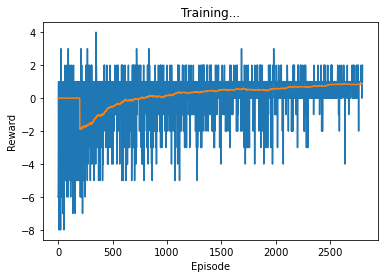

No. of false positives: 0


In [13]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
    
    #if(eps <= 0.1):
    #    em.env.sc_xyz=np.array([])
    #    em.env.ch_model = 'uma-los'
    #if ((episode+1) == 3500):
    #    em.env.ch_model = 'uma-los'
    #    em.env.sc_xyz = np.array([])
        #train_steps = 0
        #strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.997)#0.1
    #if ((episode+1) == 3900):
    #    train_steps=0
    #    strategy =EpsilonGreedyStrategy(1.0, eps_end, 0.9983, 3500)#0.1
    #    if PRIORITIZED_REPLAY:
    #        beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)
    #if (episode % 50 == 0):
    #em.env.sc_xyz = eps_scpts[episode]
    if ((episode+1) > 2700):    
        obs = em.test_reset(np.array([[-100,-100,21.5]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode])
        test_txbdir = (test_txbdir + 1) % em.env.N_tx
    else:
        obs = em.reset(ch_randvals[episode])

    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append(em.env.tx_bdir*(180/np.pi))
        rx_dirs.append(em.env.rx_bdir*(180/np.pi))
        data_rates.append(em.env.rate)

        action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em.step(action)
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        if memory.can_provide_sample():
            
            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()
            
            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)
            
        timestep +=1
        if done:
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            #plot(episode_rewards, 100)
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) > 2700):
                
                test_data_rates.append(data_rates[-1])
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
                print("max exh_rate: {}, max_action_ndx: {}\n".format(max_exh_rate, max_action_ndx))
                
            timestep = 0
            break
            
    for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

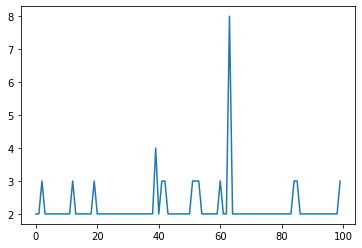

2.2 100


In [14]:
fig=plt.figure()
min_ndx=0
max_ndx=100
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [15]:
print(em.env.ch_model)
print(em.env.sc_xyz)
print(em.env.dqnobs_counter)

uma-los
[]
[30, 23, 37, 28, 28, 32, 26, 21, 30, 28, 23, 30, 41, 28, 19, 21, 45, 43, 47, 45, 51, 39, 35, 48, 27, 27, 26, 21, 30, 40, 26, 35, 26, 34, 34, 31, 25, 19, 26, 33, 26, 32, 30, 27, 27, 23, 28, 35, 30, 36, 31, 33, 22, 26, 24, 22, 31, 34, 35, 25, 23, 19, 26, 25, 34, 34, 33, 35, 32, 26, 28, 33, 28, 33, 19, 30, 31, 25, 26, 27, 26, 17, 18, 30, 28, 18, 28, 23, 34, 23, 23, 29, 26, 25, 30, 22]


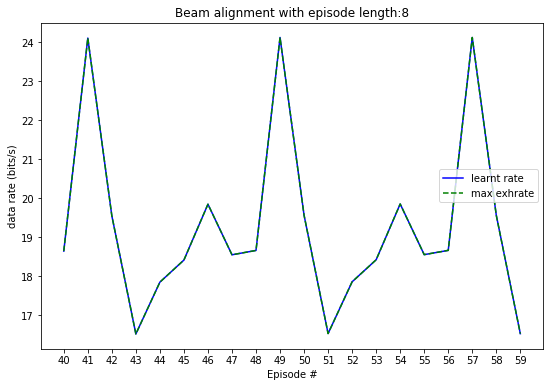

In [16]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.legend(['learnt rate','max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

## Simulation 2: BeamAlignment over location MAB vs DQN for slow fading

In [35]:
#Apply same channel values to BeamMap and DQN
N_iter = 100
selected_chvals = ch_randvals[2700:2700+N_iter]
selected_loc = np.array([[-100,-100,21.5]])
mabtest_datarates = []
mabtestmin_exhrates =[]
mabtestmax_exhrates =[]
#Task1: Update MAB BeamMap with selected channelvals
loc_ndx = 0
#for xloc in mab_env.rx_xcov:
#    for yloc in mab_env.rx_ycov:
#        tx_loc = np.array([[xloc, yloc, 0]])
#        if (np.all(tx_loc == selected_loc)):
 #           print(tx_loc)
 #           break
 #       loc_ndx = loc_ndx +1
break_flag = False
for xloc in mab_env.rx_xcov:
    for yloc in mab_env.rx_ycov:
        for zloc in mab_env.rx_zcov:
            tx_loc = np.array([[xloc, yloc, zloc]])
            if (np.all(tx_loc == selected_loc)):
                break_flag = True
                break
            if break_flag:
                break
            loc_ndx = loc_ndx +1
        if break_flag:
            break
        
            
tbdir_ndx = 0            
for i in range(N_iter):    
    print("tbdir_ndx: {}, loc_ndx: {}".format(tbdir_ndx, loc_ndx))
    #Qvals = Loc_Qvals[loc_ndx+tbdir_ndx]
    #num_selections = Loc_numselections[loc_ndx+tbdir_ndx]
    #if ((4100+i) % 50 == 0):
    Loc_count[loc_ndx*num_actions+tbdir_ndx] += 1
    #mab_env.sc_xyz = eps_scpts[4100+i]
    totalrwd, best_action_ndx, datarate, min_exhrate, max_exhrate= implement_gUCB(i, num_actions, mab_env, selected_loc, tbdir_ndx, Loc_Qvals[loc_ndx*num_actions+tbdir_ndx], Loc_numselections[loc_ndx*num_actions+tbdir_ndx], selected_chvals[i])
    
    #Loc_Qvals[loc_ndx+tbdir_ndx]= Qvals
    #Loc_numselections[loc_ndx+tbdir_ndx]=num_selections
    
    mabtest_datarates.append(datarate)
    mabtestmin_exhrates.append(min_exhrate)
    mabtestmax_exhrates.append(max_exhrate)
    
    BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx
    tbdir_ndx = (tbdir_ndx +1) % 8


for tbdir_ndx in range(mab_env.N_tx):
    print('loc: {}, tbdir_ndx: {}, best_action_ndx: {}'.format(selected_loc, tbdir_ndx, BeamMap[str(selected_loc[0][0])+','+ str(selected_loc[0][1]) + ',' +str(selected_loc[0][2])+','+str(tbdir_ndx)]))

tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2
tbdir_ndx: 0, loc_ndx: 2
tbdir_ndx: 1, loc_ndx: 2
tbdir_ndx: 2, loc_ndx: 2
tbdir_ndx: 3, loc_ndx: 2
tbdir_ndx: 4, loc_ndx: 2
tbdir_ndx: 5, loc_ndx: 2
tbdir_ndx: 6, loc_ndx: 2
tbdir_ndx: 7, loc_ndx: 2


In [36]:
print(Loc_count)

[342, 372, 318, 318, 341, 361, 313, 335, 347, 331, 360, 346, 327, 312, 335, 342, 387, 375, 353, 346, 341, 345, 324, 329, 336, 313, 345, 347, 346, 363, 325, 325, 365, 334, 333, 336, 330, 356, 325, 321, 329, 337, 339, 346, 347, 331, 326, 345, 350, 342, 377, 314, 336, 346, 316, 319, 349, 354, 304, 351, 337, 332, 327, 346, 333, 339, 304, 362, 355, 362, 335, 310, 311, 332, 325, 352, 342, 362, 337, 339, 340, 331, 319, 369, 360, 368, 317, 296, 344, 286, 364, 336, 344, 350, 358, 318]


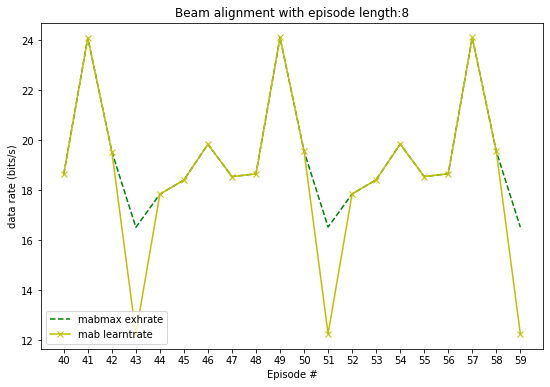

In [37]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'mab learntrate'])
plt.legend(['mabmax exhrate', 'mab learntrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

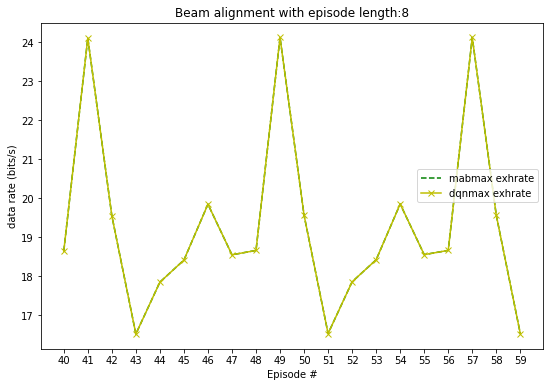

In [28]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'mab learntrate'])
plt.legend(['mabmax exhrate', 'dqnmax exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [39]:
import pandas as pd

column_names=["dqn_rate", "dqn_maxexh_rate", "dqn_minexh_rate", "cab_rate", "cab_maxexh_rate", "cab_minexh_rate"]

df = pd.DataFrame(columns=column_names)

df["dqn_rate"] = test_data_rates
df["dqn_maxexh_rate"] = test_maxexh_rates
df["dqn_minexh_rate"] = test_minexh_rates
df["cab_rate"] = mabtest_datarates
df["cab_maxexh_rate"] = mabtestmax_exhrates
df["cab_minexh_rate"] = mabtestmin_exhrates

#filename="070820_cab_dqn_2.csv"
#df.to_csv(filename, sep=',')

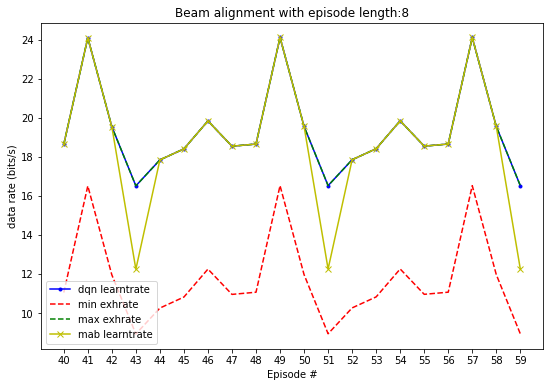

In [38]:
fig = plt.figure(figsize=[9, 6])
min_ndx=40
max_ndx=60
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b.-', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtest_datarates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), mabtestmax_exhrates[min_ndx:max_ndx], 'g--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'yx-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')
plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['dqn learntrate','min exhrate', 'max exhrate', 'mab learntrate'])
#plt.legend(['max exhrate', 'mab learntrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

## Simulation 1: Beamalignment with channel variation in online manner